In [9]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import scipy.stats as stats

import seaborn as sns
import json
import openai
import random
import os
import collections
import copy

with open('params.json') as f:
    params = json.load(f)

openai.api_key = params['OPENAI_API_KEY']
openai.organization = params['OPENAI_ORG']


def get_response(prompt, model='gpt-3.5-turbo', temperature=0.9, system_prompt="You are mimicking a real-life person who wants to make friends."):
    result = openai.ChatCompletion.create(
    model=model,
    temperature=temperature,
    messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
    ])

    return result.choices[0]['message']['content']


def summarize_reasons(filename):
    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:

        data.append(json.loads(line))

    reason_list = collections.defaultdict(list)

    for d in data:        
        for results in d["reasons"]:
            for result in results:
                if result and 'reason' in result.keys():
                    reason_list[d['temperature']].append(result['reason'])

    for k, v in sorted(reason_list.items()):    
        print(f'For temperature {k} the top 3 reasons are:')
        prompt = f"""
        # Task
        You are given a list of reasons and your task is to summarize them. You must identify the general pattern in the reasons and summarize them in a few sentences.
        You should avoid identifying specific persons.

        # Input
        The input is a list of reasons. The list is given below after chevrons:
        <REASONS>
        {json.dumps(random.sample(v, 50), indent=4)}
        </REASONS>
        """

        ans = get_response(prompt, temperature=0.9, system_prompt="You are a helpful assistant")

        print(ans)


def print_reasons(filename):
    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:

        data.append(json.loads(line))

    for d in data:
        if d["n"] == 50 and d["simulation"] == 0:
            print(f'n = {d["n"]}, simulation = {d["simulation"]}, temperature = {d["temperature"]}')
            
            for result in d["reasons"]:
                
                    try:
                        print('\t' + result['reason'])
                    except:
                        pass

def generate_individuals(n):
    profiles = []

    hobbies = ['reading', 'writing', 'cooking', 'baking', 'running', 'swimming', 'hiking', 'camping', 'fishing', 'hunting']
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown', 'black', 'white']
    
    # Locations in the US
    locations = ['New York City', 'Boston', 'Washington DC', 'Philadelphia', 'Pittsburgh', 'Chicago', 'Detroit', 'Atlanta', 'Miami', 'Dallas']

    for i in range(n):
        profile = {
            'name' : i,
            'hobby' : random.choice(hobbies),
            'favorite color' : random.choice(colors),
            'location' : random.choice(locations)
        }

        profiles.append(profile)

    with open('profiles.jsonl', 'w+') as f:
        [f.write(json.dumps(profile) + '\n') for profile in profiles]


def network_growth(n0, temperature, method='llm'):
    with open('profiles.jsonl') as f:
        profiles = f.read().splitlines()
        profiles = [json.loads(profile) for profile in profiles]

    profiles = profiles[:n0]

    G = nx.Graph()
    G.add_nodes_from(range(n0))

    Gs = []
    results = []

    for t in range(n0):

        if method == 'llm':
            result = select_neighbor(G, t, profiles, temperature)

            if result:
                for r in result:
                    v = r['name']
                    G.add_edge(t, v, similarity=r['similarity'])
                results.append(result)
        elif method in ['random', 'homophilous', 'heterophilous']:
            if method == 'random':
                new_nodes = random.sample(list(set(G.nodes()) - set([t])), 4)
            elif method == 'homophilous':
                new_nodes = list(sorted([v for v in G.nodes() if v != t], key=lambda v: len(set(profile_set(profiles[t])) & profile_set(profiles[v])), reverse=True))[:4]
            elif method == 'heterophilous':
                new_nodes = list(sorted([v for v in G.nodes() if v != t], key=lambda v: len(set(profile_set(profiles[t])) & profile_set(profiles[v]))))[:4]
            
            for v in new_nodes:
                intersection = list(set(profile_set(profiles[t])) & profile_set(profiles[v]))
                union = list(set(profile_set(profiles[t])) | profile_set(profiles[v]))
                similarity = len(intersection)
                G.add_edge(t, v, intersection=intersection, union=union, similarity=similarity)
            
            results.append([{'name' : v, 'intersection' : intersection, 'union' : union, 'similarity' : similarity} for v in new_nodes])
       
        Gs.append(G.copy())

    return Gs, results

def profile_set(p):
    return set([p['hobby']] + [p['favorite color']] + [p['location']])

def select_neighbor(G, t, profiles, temperature):
    candidate_profiles = []
    for v in G.nodes():
        if v != t:          
            candidate_profiles.append(profiles[v])
    

    prompt = f"""
    # Task
    Your task is to select a set of people to be friends with.

    # Profile
    Your profile is given below after chevrons:
    <PROFILE>
    {json.dumps(profiles[t])}
    </PROFILE>

    # Candidate Profiles
    The cadidate profiles to be friends with are given below after chevrons:

    <PROFILES>
    {json.dumps(candidate_profiles)}
    </PROFILES>

    # Output
    The output should be given a list of JSON objects with the following structure

    [
        {{
            "name" : name of the person you selected,
            "reason" : reason for selecting the person
        }}, ...
    ]

    # Notes
    - The output must be a list of JSON objects ranked in the order of preference.
    - You can make at most 4 selections.
    
    ```json
    """   

    for i in range(10):
        try:
            results = json.loads(get_response(prompt, temperature=temperature).split('```')[0])
            filtered_results = []
            for result in results:
                if result['name'] in G.nodes():
                    v = result['name']
                    result['intersection'] = list(profile_set(profiles[t]) & profile_set(profiles[v]))
                    result['union'] = list(profile_set(profiles[t]) | profile_set(profiles[v]))
                    result['similarity'] = len(result['intersection'])
                    filtered_results.append(result)

            print(f'Node: {t}, Results: {filtered_results}')

            return filtered_results

        except Exception as e:
            print(e)
      

def run_network_formation_experiment(n_min, n_max, n_step, num_simulations, outfile, temperatures, method):
    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['n'], scenario['simulation'], scenario['temperature']))

        exit()

    f = open(outfile, 'a+')


    for n in range(n_min, n_max + 1, n_step):
        for i in range(num_simulations):
            for temperature in temperatures:
                if (n, i, temperature) in saved_scenarios:
                    print(f'Skipping simulation for n={n}, i={i}, temperature={temperature}')
                    continue
                else:
                    print(f'Running simulation for n={n}, i={i}, temperature={temperature}')

                    Gs, reasons = network_growth(n, temperature=temperature, method=method)

                    temp = {
                        'n' : n,
                        'temperature' : temperature,
                        'simulation' : i,
                        'graphs' : [nx.to_dict_of_dicts(G) for G in Gs],
                        'reasons' : reasons
                    }    

                    f.write(json.dumps(temp) + '\n')            

                if method != 'llm':
                    break

    f.close()

def draw_graph(G, ax):

    pos = nx.spring_layout(G)
   
    nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()), node_size=20, node_color='magenta', ax=ax)

    edge_widths = [1 + G.edges[u, v]['similarity'] for (u, v) in G.edges()]

    nx.draw_networkx_edges(G, pos, edgelist=list(G.edges()), width=edge_widths, edge_color='black', alpha=0.5, ax=ax)

    ax.set_axis_off()


def analyze_experiments(filename):

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))


    wasserstein_distance = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list) }
   
    for d in data:
        Gs = []
        for graph in d['graphs']:
            G = nx.from_dict_of_dicts(graph)
            G.remove_edges_from(nx.selfloop_edges(G))
            G.remove_nodes_from(list(nx.isolates(G)))

            Gs.append(G)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        fig.suptitle(f'Graph created based on Principle 3 with $n = {d["n"]}$, temperature={d["temperature"]}')

        G_homophilous = network_growth(d['n'], d['temperature'], method='homophilous')[0][-1]
        G_heterophilous = network_growth(d['n'], d['temperature'], method='heterophilous')[0][-1]
        G_random = network_growth(d['n'], d['temperature'], method='random')[0][-1]

        ax[0].set_title(f'Graph')
        draw_graph(Gs[-1], ax=ax[0])

        edge_similarity_distribution = [G.edges[u, v]['similarity'] for (u, v) in Gs[-1].edges()]
        edge_similarity_distribution_homophilous = [G_homophilous.edges[u, v]['similarity'] for (u, v) in G_homophilous.edges()]
        edge_similarity_distribution_heterophilous = [G_heterophilous.edges[u, v]['similarity'] for (u, v) in G_heterophilous.edges()]
        edge_similarity_distribution_random = [G_random.edges[u, v]['similarity'] for (u, v) in G_random.edges()]

        wasserstein_distance['homophilous'][d['n'], d['temperature']].append(stats.wasserstein_distance(edge_similarity_distribution, edge_similarity_distribution_homophilous))
        wasserstein_distance['heterophilous'][d['n'], d['temperature']].append(stats.wasserstein_distance(edge_similarity_distribution, edge_similarity_distribution_heterophilous))
        wasserstein_distance['random'][d['n'], d['temperature']].append(stats.wasserstein_distance(edge_similarity_distribution, edge_similarity_distribution_random))
       
        sns.histplot(edge_similarity_distribution, ax=ax[1], label='LLM', discrete=True, stat='density')
        ax[1].xaxis.set_major_locator(mticker.MultipleLocator(1))
        
        ax[1].set_xlabel('Number of Common Attributes')
        ax[1].set_ylabel('Probability of Edge Creation')
        ax[1].legend()

        fig.tight_layout()
        fig.savefig(f'figures/principle_3/principle_3_profiles_{d["n"]}_{d["simulation"]}_{d["temperature"]}.png')

    fig, ax = plt.subplots(figsize=(5, 5))

    fig.suptitle(f'Wasserstein Distances between LLM and Null Models')

    ax.set_xlabel('Temperature')
    ax.set_ylabel('Wasserstein Distance')


    wasserstein_distance_means = { 'homophilous' : [], 'llm' : [], 'heterophilous' : [] }
    wasserstein_distance_stds = { 'homophilous' : [], 'llm' : [], 'heterophilous' : [] }

    for method in ['homophilous', 'random', 'heterophilous']:
        for i, k in enumerate(sorted(wasserstein_distance[method].keys())):
            v = np.array(wasserstein_distance[method][k])
            mean = v.mean()
            std = v.std()

            wasserstein_distance_means[method].append(mean)
            wasserstein_distance_stds[method].append(std)

    for method in ['homophilous', 'random', 'heterophilous']:
        if method == 'homophilous':
            label = 'Most Similar'
        elif method == 'heterophilous':
            label = 'Least Similar'
        else:
            label = method.capitalize()
        ax.plot(np.arange(len(wasserstein_distance[method])), wasserstein_distance_means[method], label=label, marker='o')
        ax.fill_between(np.arange(len(wasserstein_distance[method])), np.array(wasserstein_distance_means[method]) - 1.96 * np.array(wasserstein_distance_stds[method]) / np.sqrt(len(wasserstein_distance[method])), np.array(wasserstein_distance_means[method]) + 1.96 * np.array(wasserstein_distance_stds[method]) / np.sqrt(len(wasserstein_distance[method])), alpha=0.2)

    ax.set_xticks(np.arange(len(wasserstein_distance['homophilous'])))
    ax.set_xticklabels([f'{k[1]}' for k in sorted(wasserstein_distance['homophilous'].keys())])
    ax.legend()

    fig.savefig('figures/principle_3/principle_3_profiles_overall.png')
   

In [2]:
# generate_individuals(50)

In [3]:
# LLM-based
run_network_formation_experiment(50, 50, 1, 10, 'outputs/principle_3_profiles_2.jsonl', [0.5, 1.0, 1.5], method='llm')

Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=0, temperature=1.0
Skipping simulation for n=50, i=0, temperature=1.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=1, temperature=1.0
Skipping simulation for n=50, i=1, temperature=1.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=2, temperature=1.0
Skipping simulation for n=50, i=2, temperature=1.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=3, temperature=1.0
Skipping simulation for n=50, i=3, temperature=1.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=4, temperature=1.0
Skipping simulation for n=50, i=4, temperature=1.5
Skipping simulation for n=50, i=5, temperature=0.5
Skipping simulation for n=50, i=5, temperature=1.0
Skipping simulation for n=50, i=5, temperature=1.5
Skipping simulation for n=50, i=6, temperature=0.5
Skipping simulation for n=50, i

/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_64271/1545545493.py:300: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))


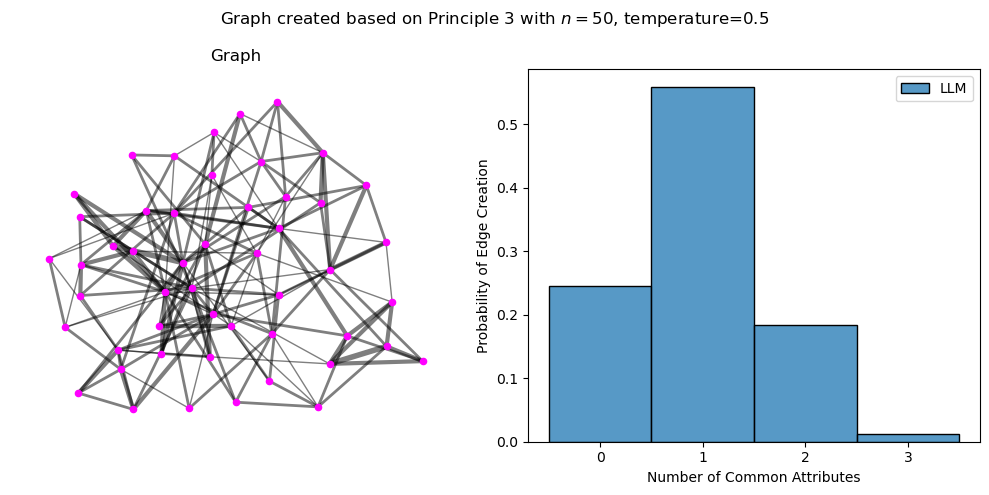

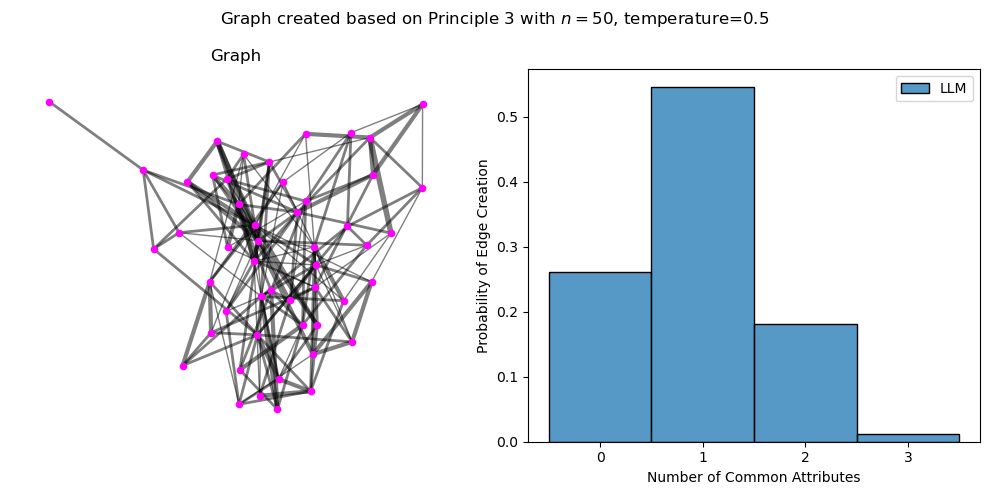

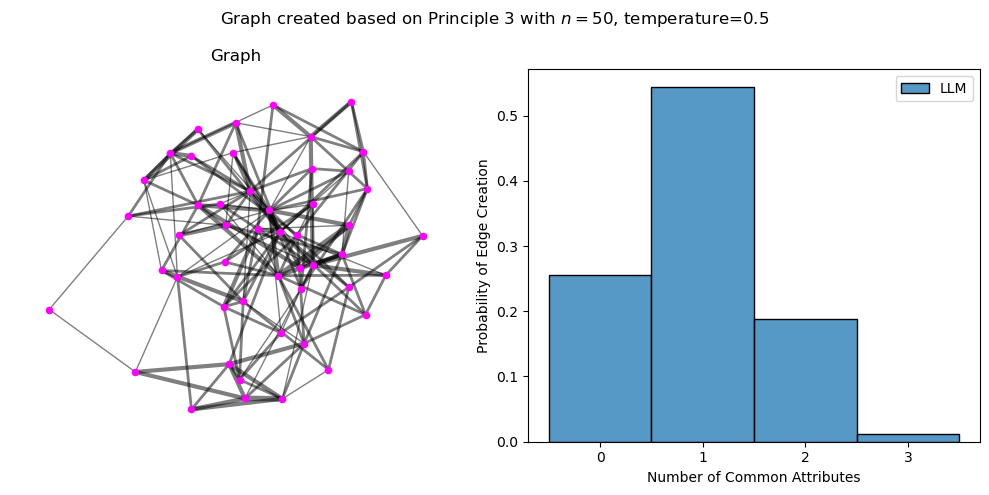

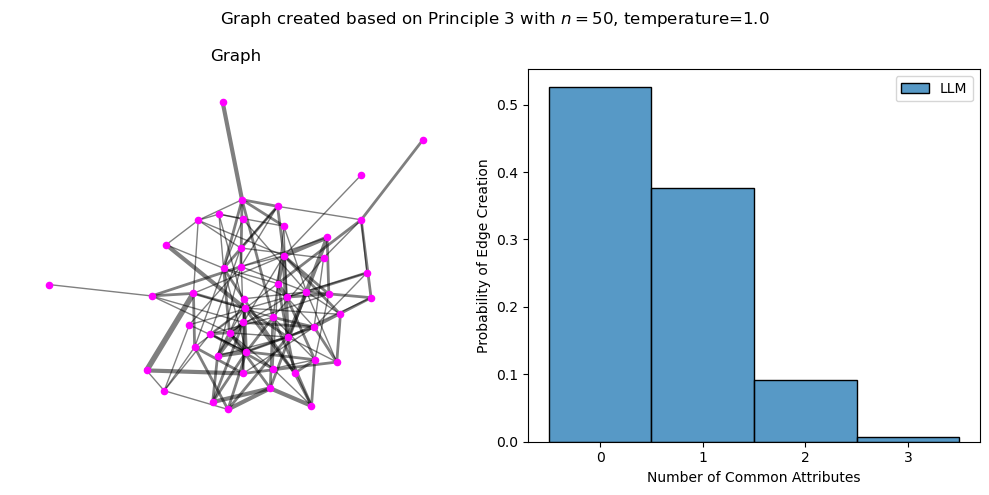

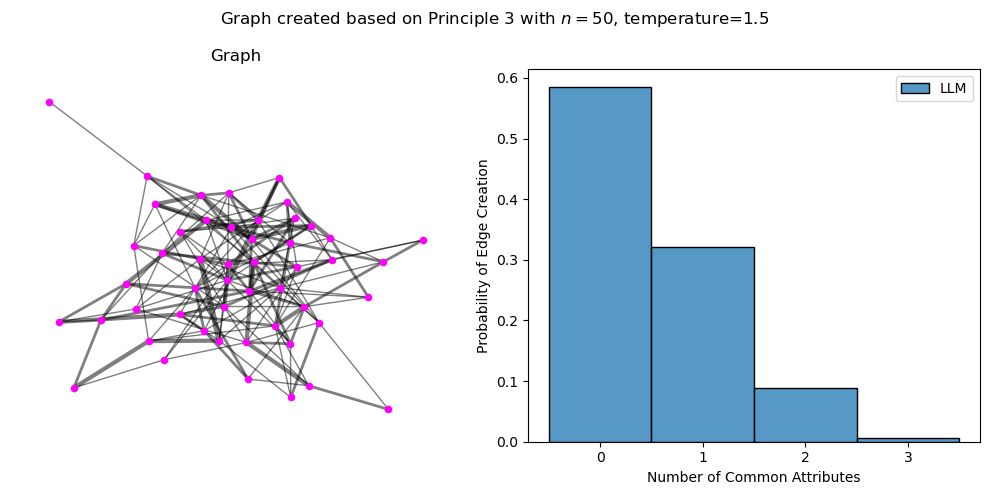

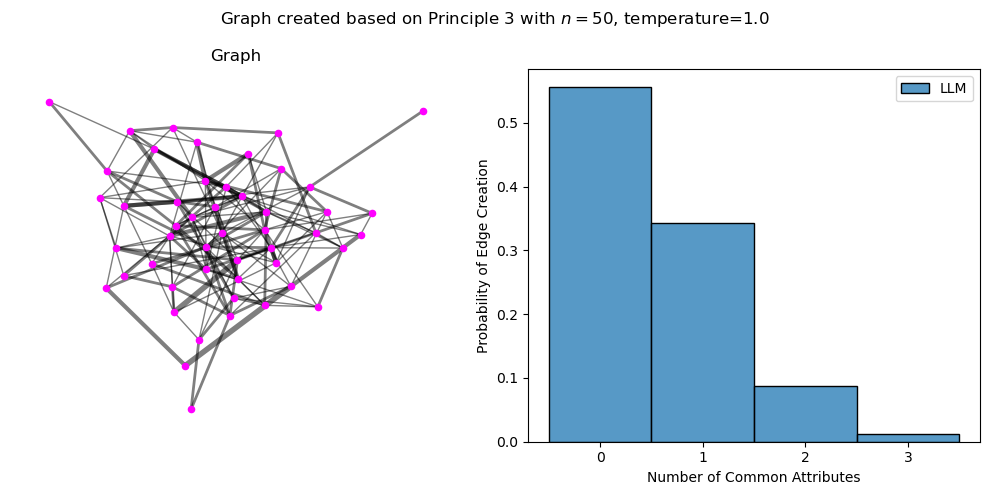

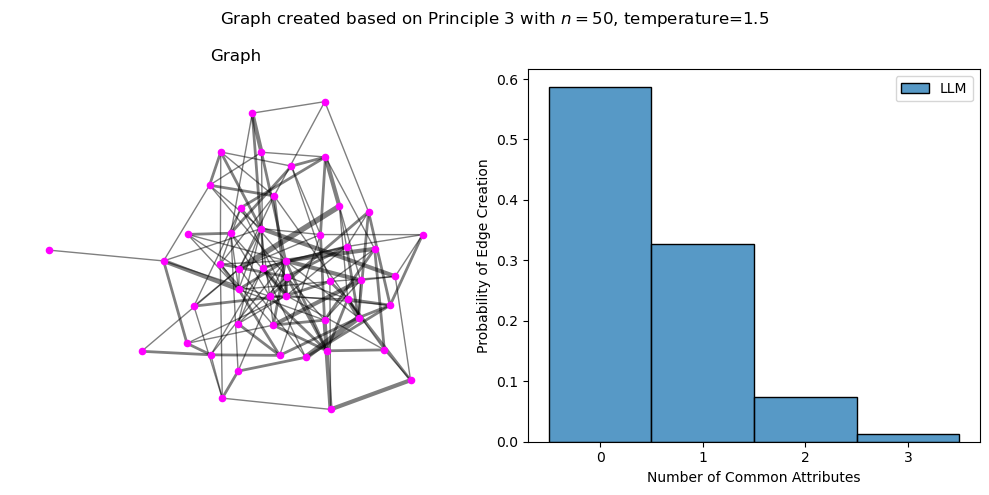

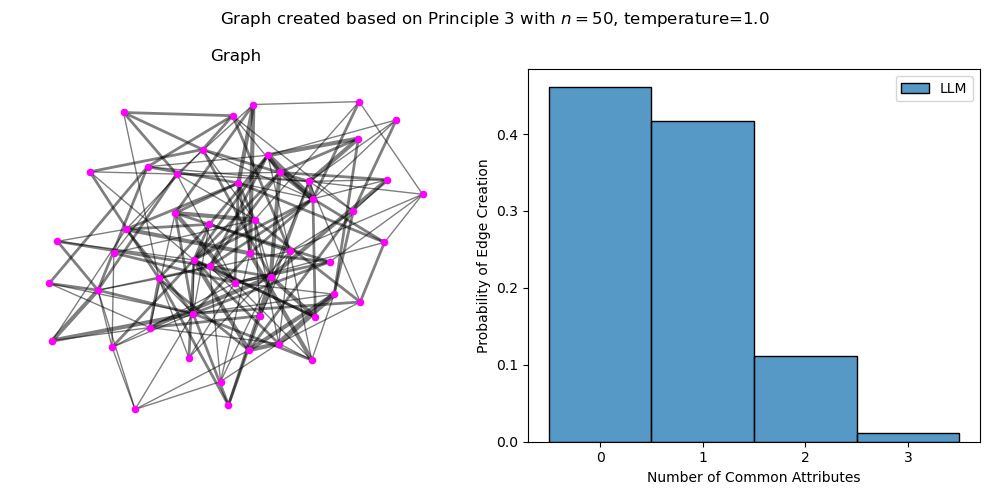

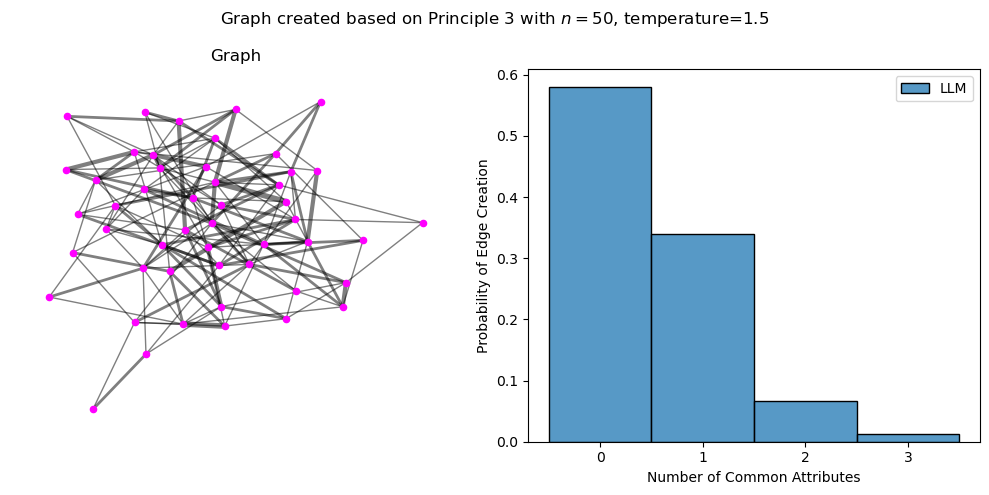

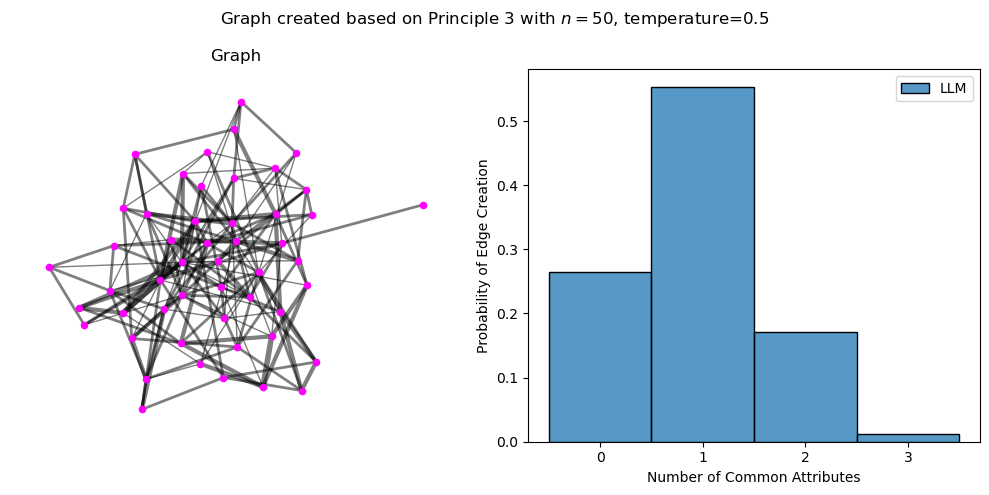

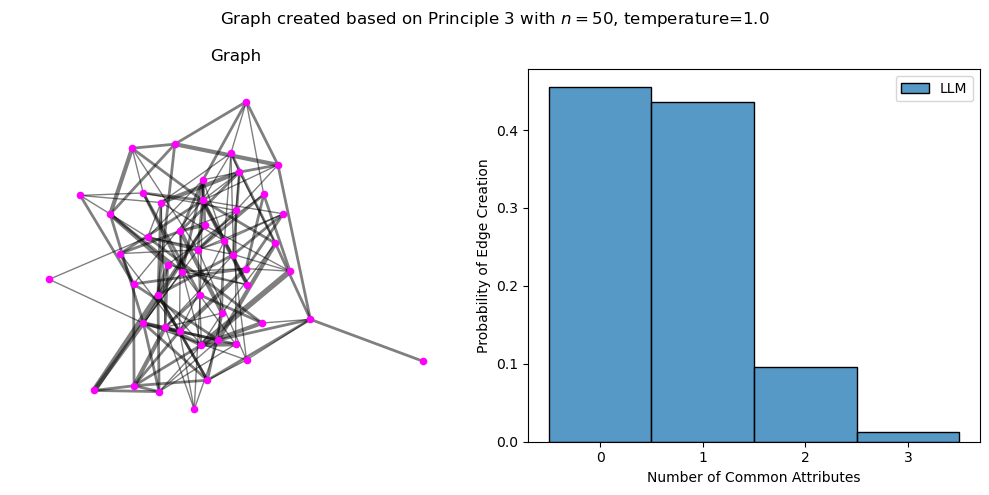

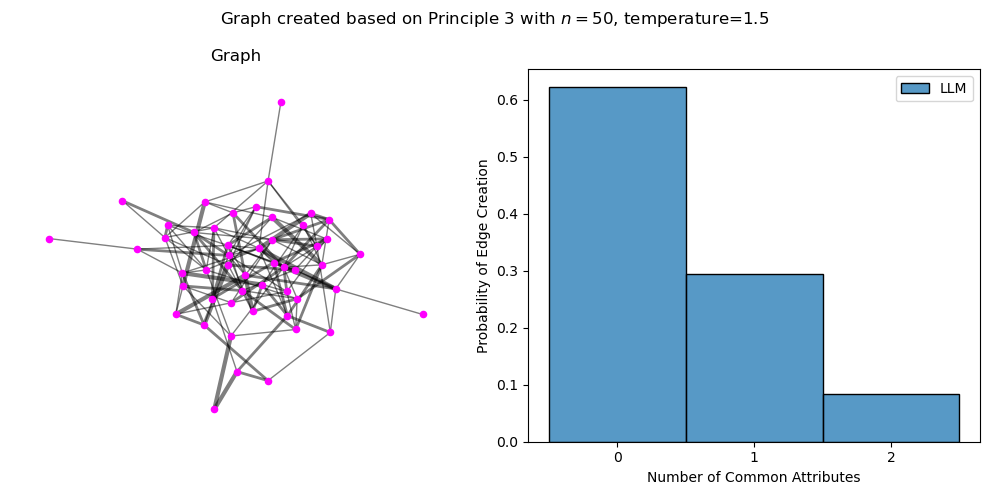

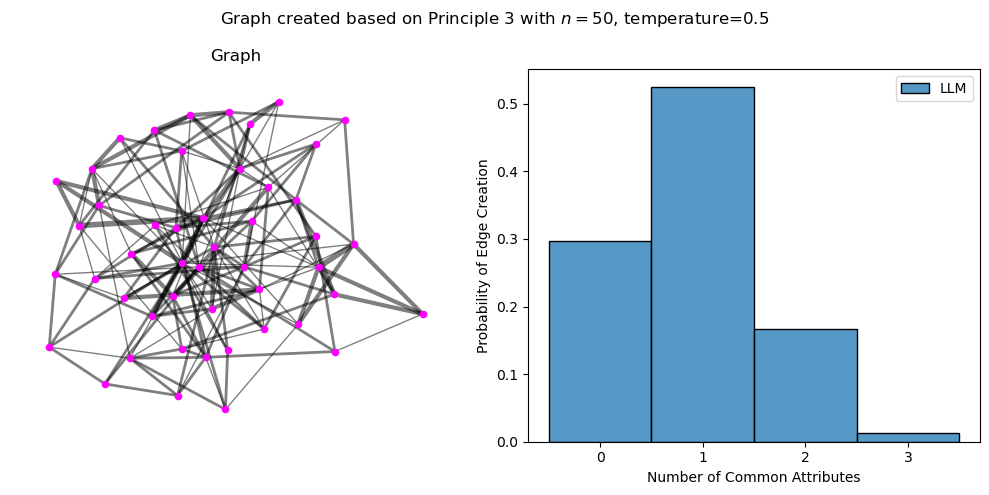

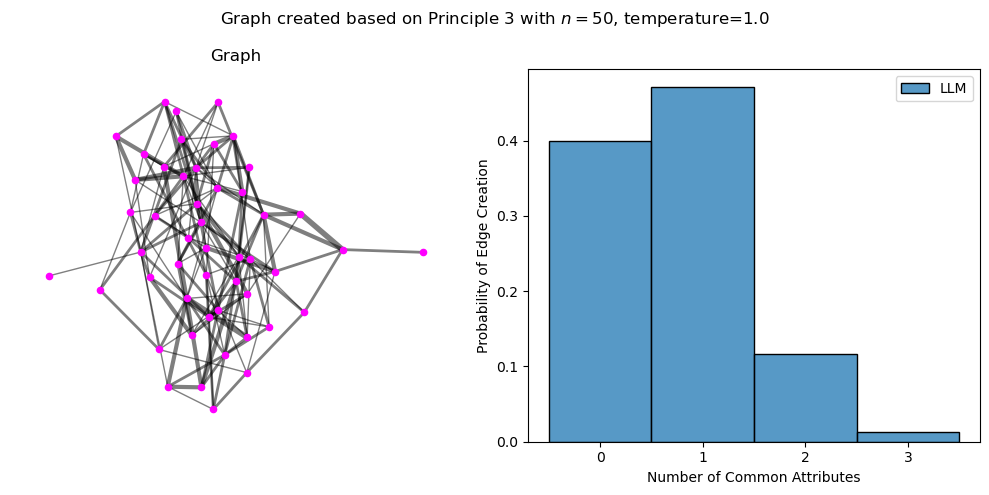

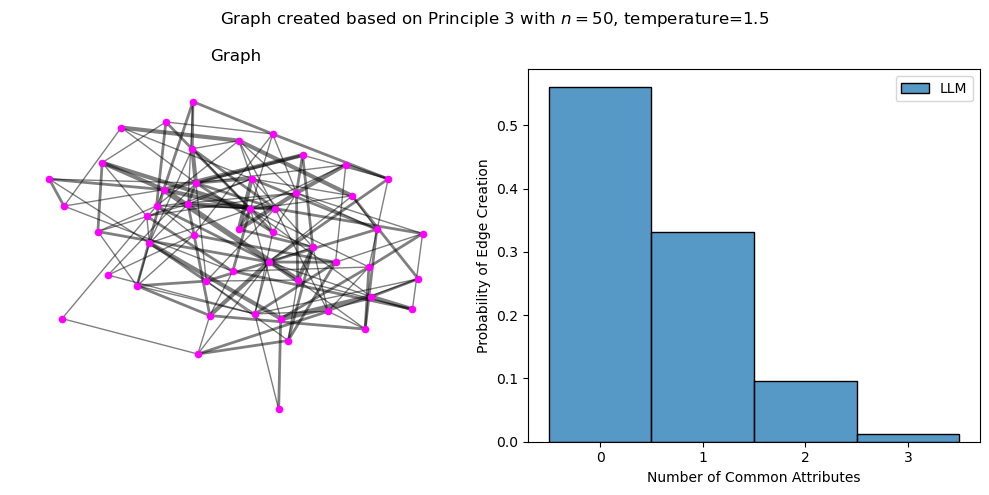

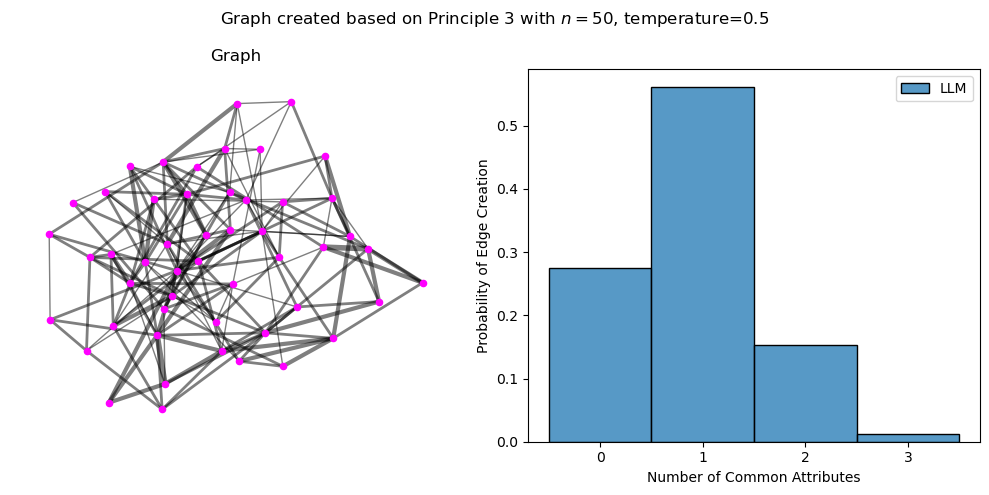

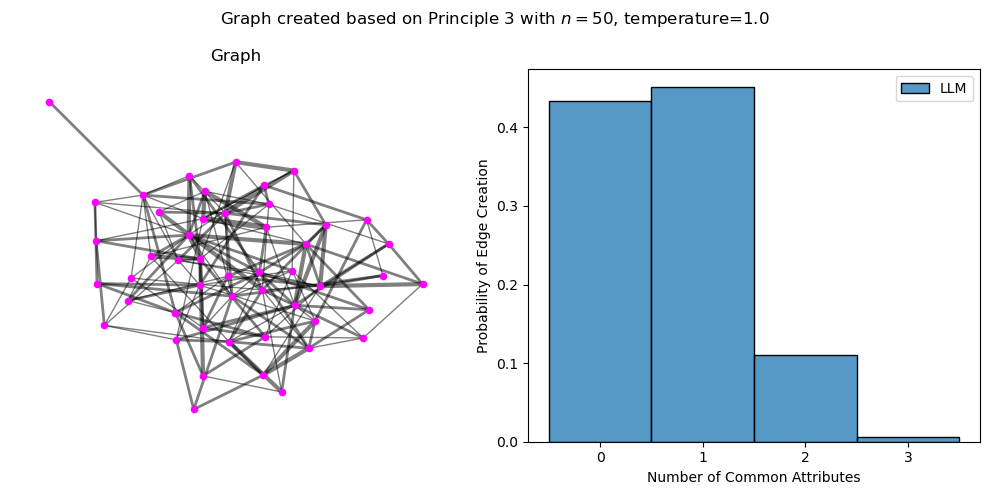

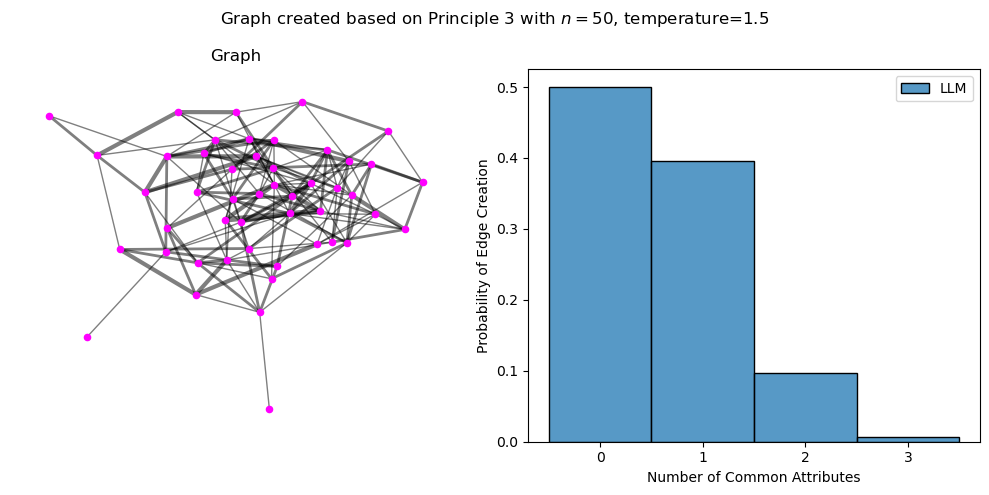

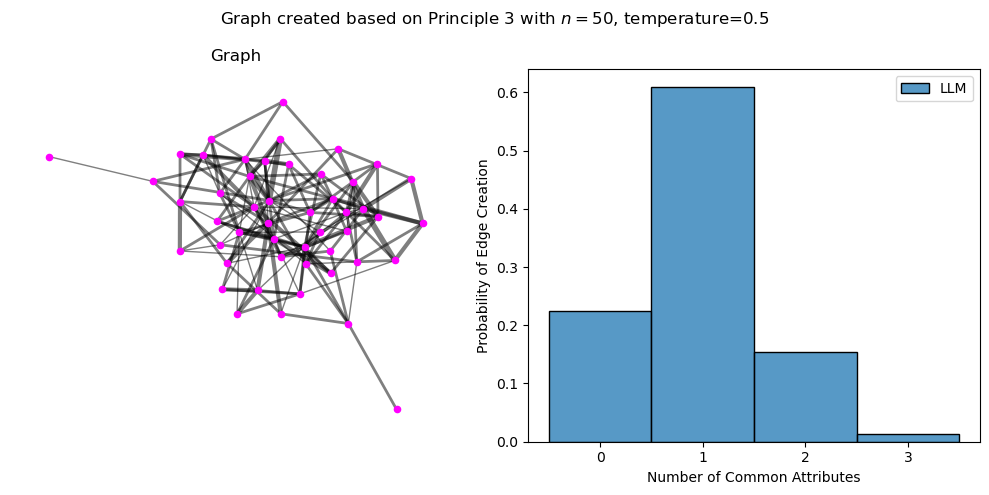

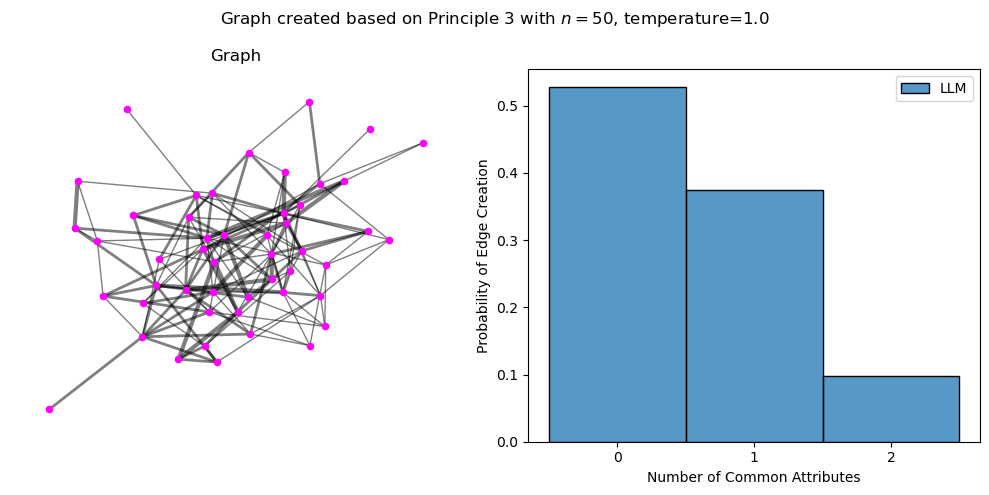

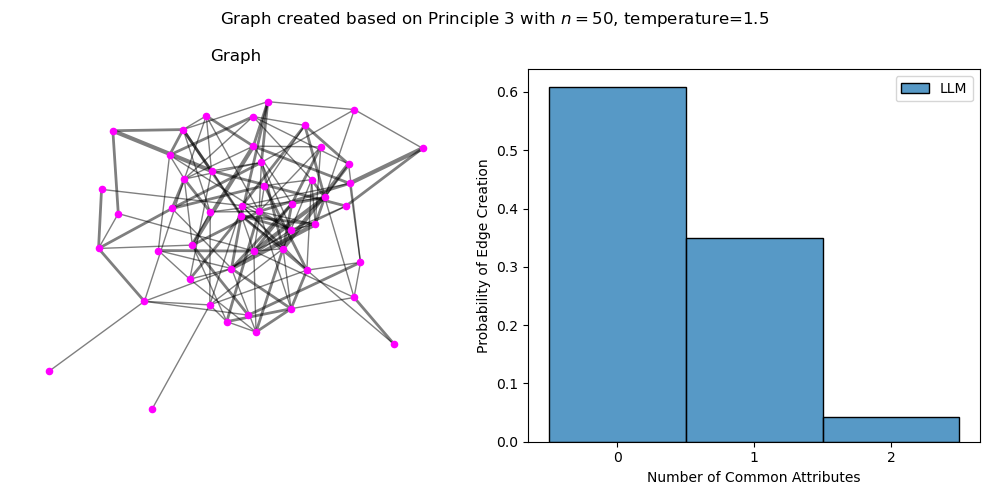

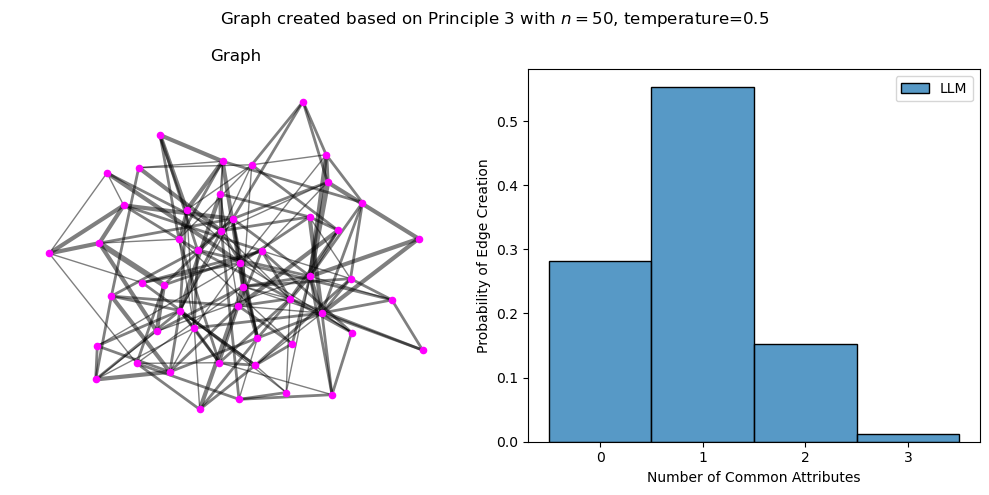

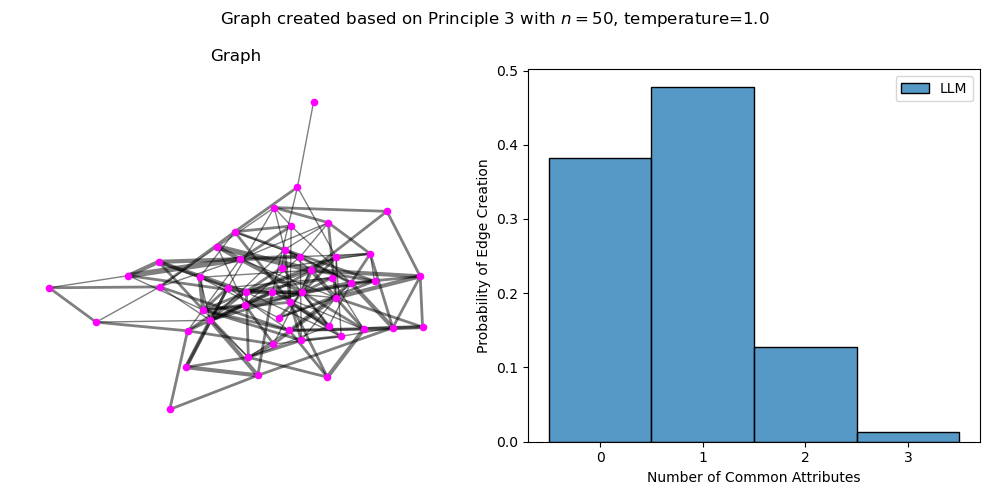

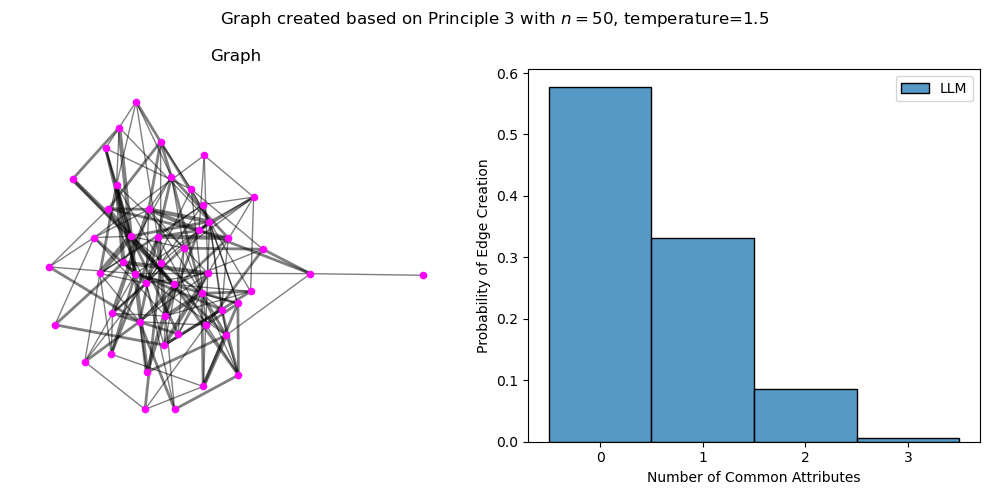

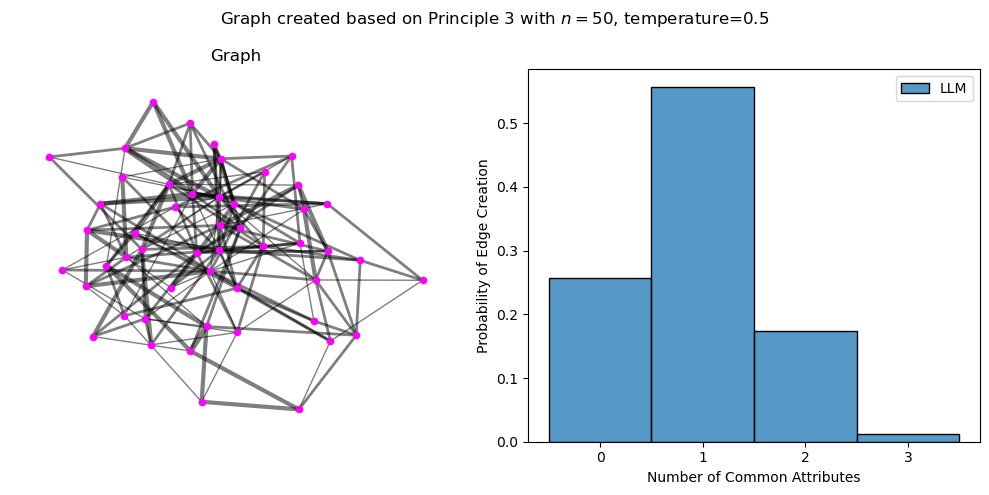

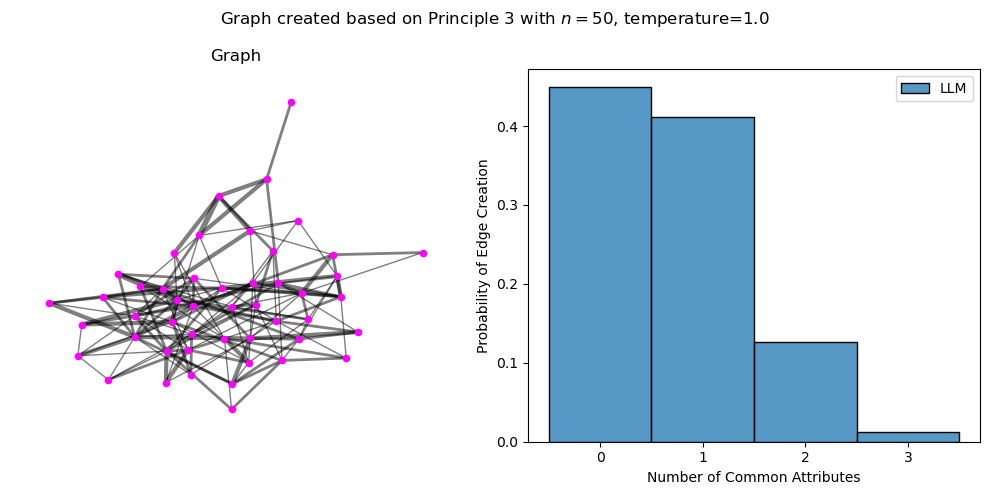

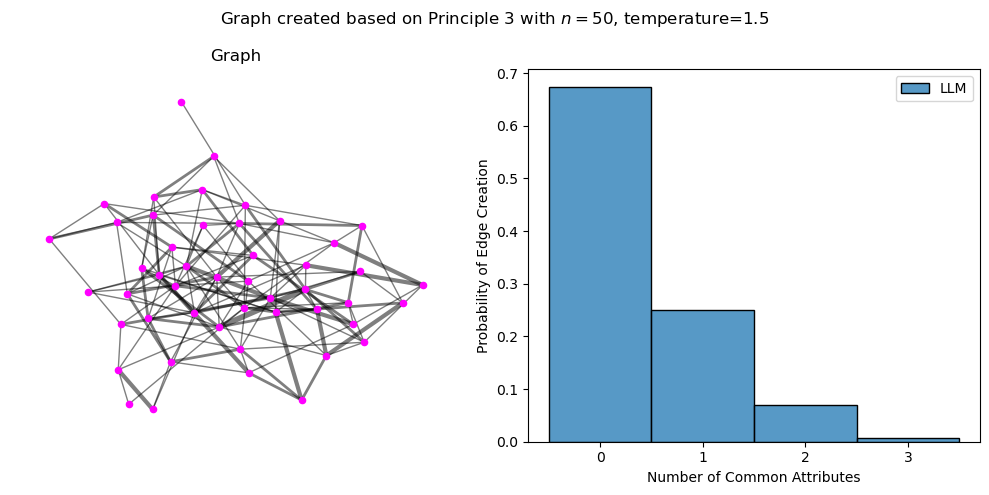

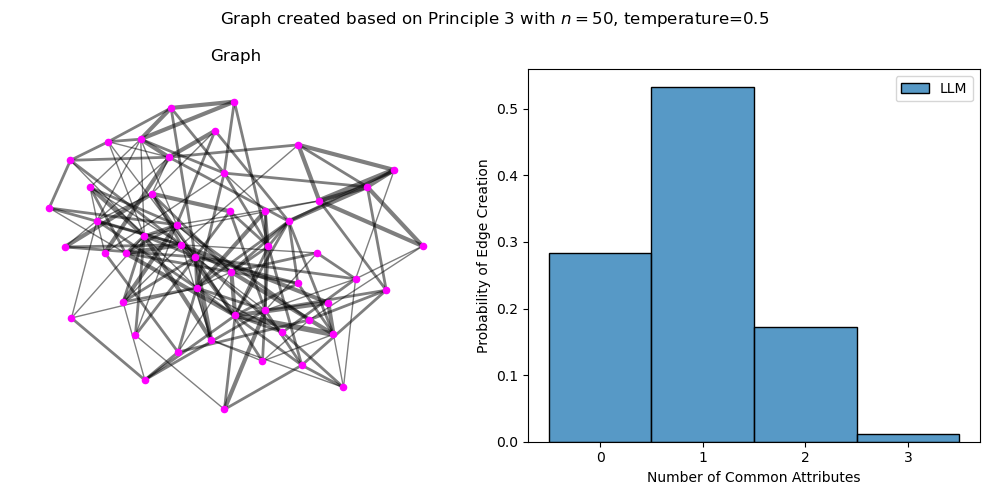

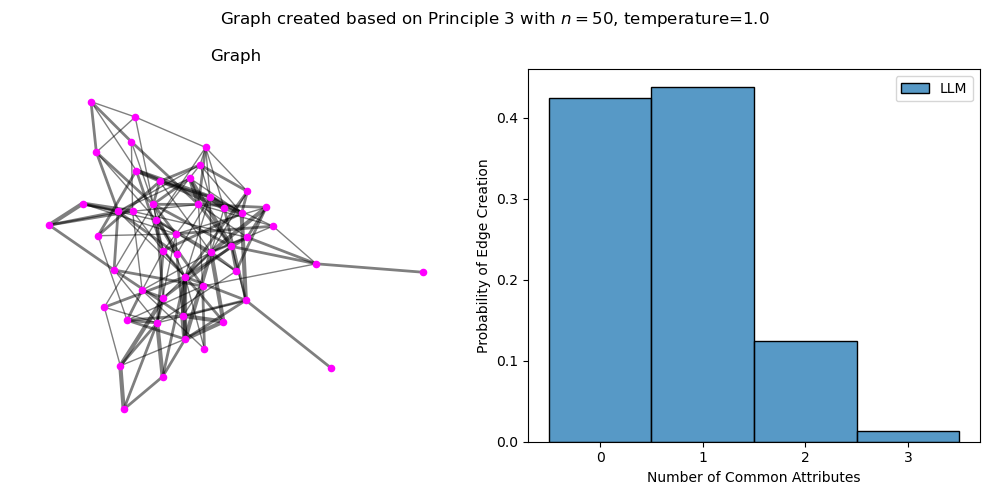

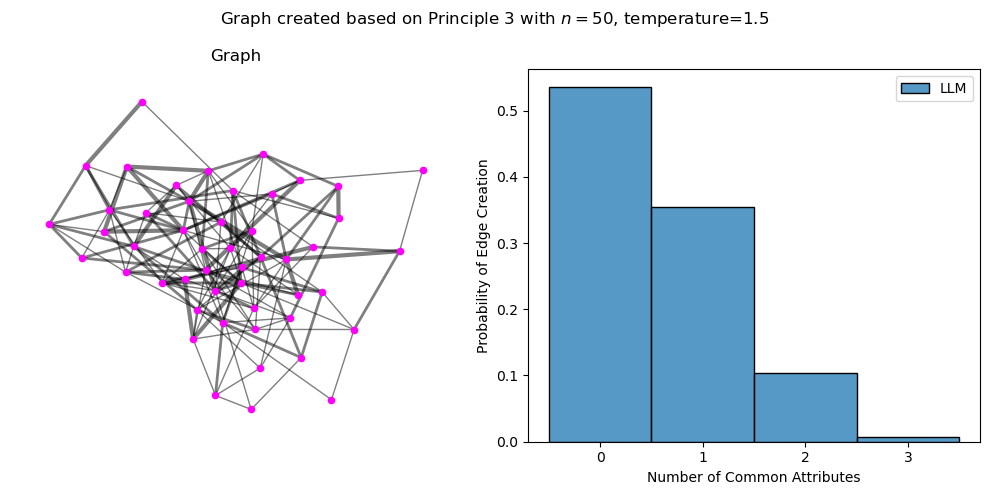

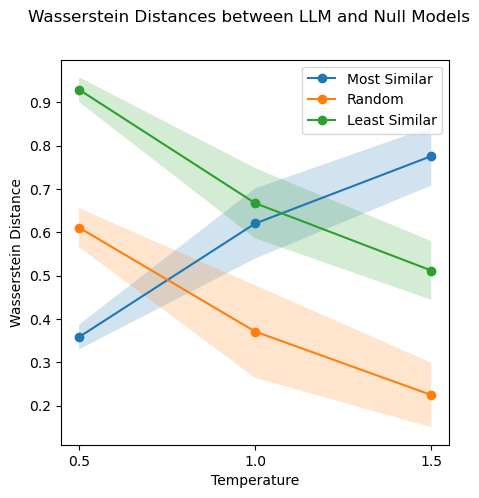

In [10]:
analyze_experiments('outputs/principle_3_profiles_2.jsonl')

In [13]:
summarize_reasons('outputs/principle_3_profiles_2.jsonl')

For temperature 0.5 the top 3 reasons are:
Based on the given list of reasons, it can be summarized that the common factors among the individuals are hobbies, favorite colors, and locations. People are connecting and forming relationships because they share hobbies such as swimming, reading, cooking, hunting, baking, hiking, fishing, and camping. They also have common favorite colors like pink, black, brown, blue, and green. Additionally, they live or are located in the same cities like Philadelphia, Chicago, Miami, Detroit, and Boston. These shared interests and locations make them compatible and likely to have similar interests.
For temperature 1.0 the top 3 reasons are:
Based on the given list of reasons, it can be summarized that there are several commonalities between the people mentioned. These commonalities include shared hobbies such as hunting, hiking, cooking, swimming, fishing, camping, and writing. Additionally, there are mentions of the same favorite colors, such as pink, 